<a href="https://colab.research.google.com/github/SwethaMagesh/Weed_classification_ML/blob/main/UNET_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the compresssed dataset file from google drive

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ZcoubWc5kEV-NO3SKNLXQ5MTsPaYmof7' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ZcoubWc5kEV-NO3SKNLXQ5MTsPaYmof7" -O dataset && rm -rf /tmp/cookies.txt

--2021-05-22 09:02:25--  https://docs.google.com/uc?export=download&confirm=9knC&id=1ZcoubWc5kEV-NO3SKNLXQ5MTsPaYmof7
Resolving docs.google.com (docs.google.com)... 172.253.117.102, 172.253.117.113, 172.253.117.138, ...
Connecting to docs.google.com (docs.google.com)|172.253.117.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-1o-docs.googleusercontent.com/docs/securesc/63drckvj0nk5hbr7g6au8k916k9jfr80/k49sj8ssus8cbd5tf55q5hcondrhvd66/1621674075000/05315663848078174434/05451672544495169855Z/1ZcoubWc5kEV-NO3SKNLXQ5MTsPaYmof7?e=download [following]
--2021-05-22 09:02:25--  https://doc-0o-1o-docs.googleusercontent.com/docs/securesc/63drckvj0nk5hbr7g6au8k916k9jfr80/k49sj8ssus8cbd5tf55q5hcondrhvd66/1621674075000/05315663848078174434/05451672544495169855Z/1ZcoubWc5kEV-NO3SKNLXQ5MTsPaYmof7?e=download
Resolving doc-0o-1o-docs.googleusercontent.com (doc-0o-1o-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connec

### Extract and unzip the file

In [ ]:
!tar -xvf dataset

## Test the images in the dataset by viewing the first 10 images

1252


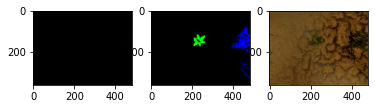

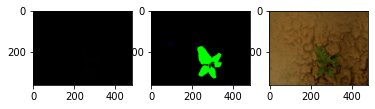

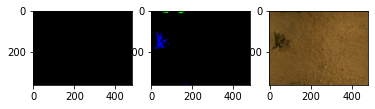

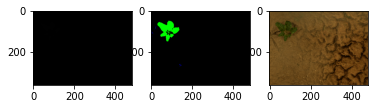

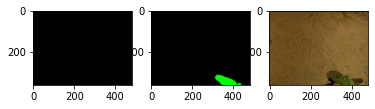

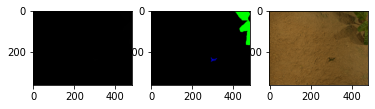

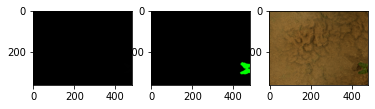

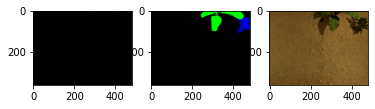

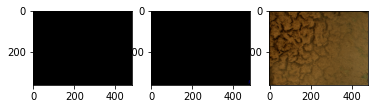

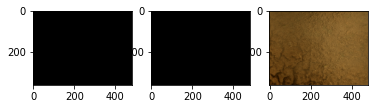

In [ ]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from os import listdir

#specifying paths
path1='/content/synthetic_sugarbeat_random_weeds/gt/'
path2='/content/synthetic_sugarbeat_random_weeds/gt_color/'
path3='/content/synthetic_sugarbeat_random_weeds/rgb/'
print(len(listdir(path1)))


#printing the first 10 files
for filename in listdir(path1)[:10]:
  image_r=cv2.imread(path1+filename)
  # image_r = cv2.cvtColor(image_r, cv2.COLOR_BGR2RGB)
  plt.subplot(1,3,1)
  
  plt.imshow(image_r)
  image_r=cv2.imread(path2+filename)
  # image_r = cv2.cvtColor(image_r, cv2.COLOR_BGR2RGB)
  plt.subplot(1,3,2)
  plt.imshow(image_r)
  # print(image_r[:,:,2])
  # print(np.count_nonzero(image_r[:,:,2]))
  image_r=cv2.imread(path3+filename)
  image_r = cv2.cvtColor(image_r, cv2.COLOR_BGR2RGB)
  plt.subplot(1,3,3)
  plt.imshow(image_r)
  plt.show()


### Specifying the parameters
- Parameter like batchsize, training data size, test data size, scaling and augmenting parameters 

### Forming a data frame df_train and df_test
- These data frames consist of the images and the mask file names with path

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn.model_selection import train_test_split
import gc; gc.enable() # memory is tight

from keras import layers, models
from keras import backend as K
from keras.optimizers import Adam

N=1252
TRAIN_SIZE=1000
TEST_SIZE=252
BATCH_SIZE = 200
EDGE_CROP = 16
NB_EPOCHS = 30
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'DECONV'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 552
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False
resized_shape=(256,256)
train_mask=[]
test_mask=[]
train_images=[]
test_images=[]
for i,file in enumerate(listdir(path1)):
  if i<TRAIN_SIZE:
    train_images.append(path3+file)
    train_mask.append(path2+file)

  else:
    test_images.append(path3+file)
    test_mask.append(path2+file)
df_train=pd.DataFrame(np.column_stack([train_images,train_mask]),columns=['images','masks'])
df_test=pd.DataFrame(np.column_stack([test_images,test_mask]),columns=['images','masks'])

df1 = df_train.sort_values(by='images')['images'].reset_index()
df2 = df_train.sort_values(by='masks')['masks'].reset_index()
# df2 = df.sort_values(by='b')['b']
df_train['images'] = df1['images']
df_train['masks'] = df2['masks']
del df1, df2

df1 = df_test.sort_values(by='images')['images'].reset_index()
df2 = df_test.sort_values(by='masks')['masks'].reset_index()
# df2 = df.sort_values(by='b')['b']
df_test['images'] = df1['images']
df_test['masks'] = df2['masks']
del df1, df2


In [ ]:
# Checking size of training dataframe
len(df_train)
df_train

,images,masks
0,/content/synthetic_sugarbeat_random_weeds/rgb/...,/content/synthetic_sugarbeat_random_weeds/gt_c...
1,/content/synthetic_sugarbeat_random_weeds/rgb/...,/content/synthetic_sugarbeat_random_weeds/gt_c...
2,/content/synthetic_sugarbeat_random_weeds/rgb/...,/content/synthetic_sugarbeat_random_weeds/gt_c...
3,/content/synthetic_sugarbeat_random_weeds/rgb/...,/content/synthetic_sugarbeat_random_weeds/gt_c...
4,/content/synthetic_sugarbeat_random_weeds/rgb/...,/content/synthetic_sugarbeat_random_weeds/gt_c...
...,...,...
995,/content/synthetic_sugarbeat_random_weeds/rgb/...,/content/synthetic_sugarbeat_random_weeds/gt_c...
996,/content/synthetic_sugarbeat_random_weeds/rgb/...,/content/synthetic_sugarbeat_random_weeds/gt_c...
997,/content/synthetic_sugarbeat_random_weeds/rgb/...,/content/synthetic_sugarbeat_random_weeds/gt_c...
998,/content/synthetic_sugarbeat_random_weeds/rgb/...,/content/synthetic_sugarbeat_random_weeds/gt_c...


In [ ]:
# Checking size of testing dataframe
len(df_test)
df_test

,images,masks
0,/content/synthetic_sugarbeat_random_weeds/rgb/...,/content/synthetic_sugarbeat_random_weeds/gt_c...
1,/content/synthetic_sugarbeat_random_weeds/rgb/...,/content/synthetic_sugarbeat_random_weeds/gt_c...
2,/content/synthetic_sugarbeat_random_weeds/rgb/...,/content/synthetic_sugarbeat_random_weeds/gt_c...
3,/content/synthetic_sugarbeat_random_weeds/rgb/...,/content/synthetic_sugarbeat_random_weeds/gt_c...
4,/content/synthetic_sugarbeat_random_weeds/rgb/...,/content/synthetic_sugarbeat_random_weeds/gt_c...
...,...,...
247,/content/synthetic_sugarbeat_random_weeds/rgb/...,/content/synthetic_sugarbeat_random_weeds/gt_c...
248,/content/synthetic_sugarbeat_random_weeds/rgb/...,/content/synthetic_sugarbeat_random_weeds/gt_c...
249,/content/synthetic_sugarbeat_random_weeds/rgb/...,/content/synthetic_sugarbeat_random_weeds/gt_c...
250,/content/synthetic_sugarbeat_random_weeds/rgb/...,/content/synthetic_sugarbeat_random_weeds/gt_c...


### Create mask 
- This function is used to create a binary mask - 0 if no weed and 1 if there is a weed
- The annotation in data set is (GREEN is CROP) and (BLUE is WEED)
- So in RGB mode, 3rd channel blue is selected, wherever there is blue in image, it is set as 1 in mask and otherwise 0 is set in mask


### Create image generator
- This is used to create image,mask as a batch which can directly be passed to a MODEL.FIT in keras


In [ ]:
def create_mask(maskpath,img_shape):
  mask=np.zeros(shape=(img_shape[0],img_shape[1],1))
  mask_img=cv2.imread(maskpath)
  mask_img=mask_img[:,:,2]
  for i in range(img_shape[0]):
    for j in range(img_shape[1]):
      if mask_img[i,j]>0:
        mask[i,j,0]=1
      else:
        mask[i,j,0]=0
  return mask

def create_images_generator(df_in, batch_size, resized_shape):
  batch_image = []
  batch_mask = []
  df_in_list = (df_in).values.tolist()
  # np.random.shuffle(df_in_list) 
    
  while True:
      for image_path, mask_path in df_in_list:
        
        image_r = cv2.imread(image_path)
        image_r = cv2.cvtColor(image_r, cv2.COLOR_BGR2RGB)
        mask_r = create_mask(mask_path, image_r.shape)
        # print("shape is ",image_r.shape) is 360x480
        image_r = cv2.resize(image_r,(resized_shape[1], resized_shape[0]))
        mask_r = cv2.resize(mask_r,(resized_shape[1], resized_shape[0]))          
                    
        batch_image.append(image_r)
        batch_mask.append(mask_r)
        
        if len(batch_mask)>=batch_size:
            yield np.float32(np.stack((batch_image), 0)/255.0), np.stack(np.float32(np.expand_dims(batch_mask, -1)), 0)
            batch_image, batch_mask = [], []

### SET ARGUMENTS for image augmentation
- rotation, flip, shear, zoom etc.

### Make augment generator
- This is used to augment the data before training. This is optional. We haven't used augmentation in the final model now. 

### cal_IOU
- This function is used to measure how accurately weed is detected. 
- This calculates the intersection area (between actual output and predicted output) divided by union area

### cal_IOU_loss
- Loss is inversely proportional to IOU
- So, we define it as negative of IOU

### We include an option to choose UPSAMPLING MODE 
- SIMPLE 
- DECONV
- Based on this, either a simple upsampling layer or a transpose convolutional layer can be used

### CREATE A UNET MODEL ARCHITECTURE
- Most important - UNET ARCHITECTURE
  - It has 2 phases: 1. DOWNSAMPLING 2. UPSAMPLING
  1. Downsampling has Convolution and Maxpooling layers repeated
    - These are repeated 4 times in our model
    - CCPCCPCCPCCP
    - Aim is to reduce the resolution of images to detect the feature
  1. Upsampling has Convolution and Upsampling layers repeated
    - These are repeated 4 times in our model
    - CCUCCUCCUCCU
  1. INBETWEEN CONCAT operation is used to combine a upsampled and a previous layer data. (This is the highlight of a UNET architecture)
  1. Finally there are convolutional and single dense layer with sigmoid activation 
  1. *NOTE: Hidden layer activation is relu*

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
args_dg = dict(featurewise_center = False, 
               samplewise_center = False, 
               rotation_range = 2, 
               width_shift_range = 0.1, 
               shear_range = 0.01,
               zoom_range = [0.9, 1.1], 
               horizontal_flip = False, 
               vertical_flip = False,
               fill_mode = 'constant',
               data_format = 'channels_last')

if AUGMENT_BRIGHTNESS:
    args_dg['brightness_range'] = [0.5, 1.5]

image_gen = ImageDataGenerator(**args_dg)

if AUGMENT_BRIGHTNESS:
    args_dg.pop('brightness_range')
mask_gen = ImageDataGenerator(**args_dg)

# In[]
def make_augment_generator(img_mask_gen, seed=None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for img_in, mask_in in img_mask_gen:
        seed = np.random.choice(range(9999))
        aug_img_in = image_gen.flow(255*img_in, 
                                 batch_size=img_in.shape[0],
                                 seed = seed, 
                                 shuffle=True)
        aug_mask_in = mask_gen.flow(mask_in, 
                                    batch_size=img_in.shape[0],
                                    seed=seed,
                                    shuffle=True)
        yield next(aug_img_in)/255.0, next(aug_mask_in)

def calc_IOU(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f*y_pred_f)
    
    return (2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
def calc_IOU_loss(y_true, y_pred):
    return -calc_IOU(y_true, y_pred)

# In[]
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)

def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple

def create_unet():
    
    # input_img = layers.Input(batch_img.shape[1:], name = 'RGB_Input')
    input_img = layers.Input((resized_shape[0],resized_shape[1],3), name = 'RGB_Input')
    pp_in_layer = input_img
             
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(pp_in_layer)
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2)) (c3)
    
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)
    
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
    
    
    u6 = upsample(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4], axis=3)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = upsample(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3], axis=3)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = upsample(16, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2], axis=3)
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c9)
    
    d = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)   
    if NET_SCALING is not None:
      d = layers.UpSampling2D(NET_SCALING)(d)
     
    seg_model = models.Model(inputs=[input_img], outputs=[d])
    seg_model.summary()
    
    return seg_model


### Define the model 
- CREATE UNET MODEL 
- COMPILE
  - Set optimiser parameter with learning rate (here 10 power -4)
  - Set loss and IOU metrics
- Generator objects for train and validation are created using **create_images_generator()** helper function mentioned earlier
- FIT THE MODEL 
  - Specify the epochs, steps per epoch and Validation data
-*This takes a lot of time. So this fitting of model is done once and stored for saving time.*
- Fit model is called for the first time or when previous saved model is not available.
- Once saved this fit part is commented


In [ ]:
# In[]

model = create_unet()
model.compile(optimizer=Adam(lr=1e-3),
              loss=calc_IOU_loss, metrics=[calc_IOU])
# In[]
# history = model.fit_generator(train_gen,
#             samples_per_epoch=40,
#                               nb_epoch=2)    
 
train_gen = create_images_generator(df_train, batch_size=BATCH_SIZE, resized_shape=resized_shape)
valid_gen = create_images_generator(df_test, batch_size=BATCH_SIZE, resized_shape=resized_shape)
# aug_gen = make_augment_generator(train_gen)
val_img, val_mask = next(valid_gen)  


#UNCOMMENT IF NO CHECKPOINT MODEL AVAILABLE
history=model.fit_generator(train_gen,
 steps_per_epoch=5,
 epochs=15,
 validation_data=(val_img, val_mask) )

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         RGB_Input[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 8)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
5/5 [==============================] - 258s 53s/step - loss: -0.0111 - calc_IOU: 0.0111 - val_loss: -0.0112 - val_calc_IOU: 0.0112
Epoch 2/15
5/5 [==============================] - 282s 59s/step - loss: -0.0118 - calc_IOU: 0.0118 - val_loss: -0.0118 - val_calc_IOU: 0.0118
Epoch 3/15
5/5 [==============================] - 294s 59s/step - loss: -0.0126 - calc_IOU: 0.0126 - val_loss: -0.0130 - val_calc_IOU: 0.0130
Epoch 4/15
5/5 [==============================] - 293s 59s/step - loss: -0.0142 - calc_IOU: 0.0142 - val_loss: -0.0162 - val_calc_IOU: 0.0162
Epoch 5/15
5/5 [==============================] - 291s 58s/step - loss: -0.0189 - calc_IOU: 0.0189 - val_loss: -0.0270 - val_calc_IOU: 0.0269
Epoch 6/15
5/5 [==============================] - 292s 58s/step - loss: -0.0358 - calc_IOU: 0.0358 - val_loss: -0.0571 - val_calc_IOU: 0.0568
Epoch 7/15
5/5 [==============================] - 291s 58s/step - loss: -0.0743 - calc_IOU: 0.0743 - val_loss: -0.0993 - val_calc_IOU: 0.0982
Epoch 

In [ ]:
history=model.fit_generator(train_gen,
 steps_per_epoch=5,
 epochs=15,
 validation_data=(val_img, val_mask) )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
5/5 [==============================] - 235s 59s/step - loss: -0.4109 - calc_IOU: 0.4109 - val_loss: -0.4050 - val_calc_IOU: 0.3984
Epoch 2/15
5/5 [==============================] - 290s 58s/step - loss: -0.4400 - calc_IOU: 0.4400 - val_loss: -0.4528 - val_calc_IOU: 0.4447
Epoch 3/15
5/5 [==============================] - 290s 58s/step - loss: -0.5274 - calc_IOU: 0.5274 - val_loss: -0.5111 - val_calc_IOU: 0.5104
Epoch 4/15
5/5 [==============================] - 291s 58s/step - loss: -0.5602 - calc_IOU: 0.5602 - val_loss: -0.5093 - val_calc_IOU: 0.5047
Epoch 5/15
5/5 [==============================] - 291s 58s/step - loss: -0.5529 - calc_IOU: 0.5529 - val_loss: -0.5272 - val_calc_IOU: 0.5239
Epoch 6/15
5/5 [==============================] - 292s 58s/step - loss: -0.5162 - calc_IOU: 0.5162 - val_loss: -0.4283 - val_calc_IOU: 0.4149
Epoch 7/15
5/5 [==============================] - 291s 58s/step - loss: -0.4996 - calc_IOU: 0.4996 - val_loss: -0.5113 - val_calc_IOU: 0.5051
Epoch 

### LOAD the saved .h5 model.

This has saved weights, it can be trained again or just used to predict the weeds in data

In [ ]:
# load and continue model
# from keras.models import load_model
# model.load_weights('/content/model.h5')
# results=model.evaluate(val_img,val_mask)
# print("The IOU measure is ")
# print(results)



# # # CONTINUE TRAINING
# history1=model.fit_generator(train_gen,
#  steps_per_epoch=4,
#  epochs=5,
#  validation_data=(val_img, val_mask) )


### PLOT the model accuracy after training the pretrained loaded model. 
(Commented unless you train the loaded saved model)


In [ ]:

# acc=history1.history['calc_IOU']
# val_acc=history1.history['val_calc_IOU']
# epochs=range(1,len(acc)+1)
# plt.plot(epochs,acc,'-b',label="TRAIN IOU")
# plt.plot(epochs,val_acc,'-r',label="VAL IOU")
# plt.title= "ACCURACY" 
# plt.xlabel("EPOCHS")
# plt.ylabel("IOU")
# plt.legend()
# plt.show()

### PLOT the accuracy for model after training for first time

7/7 [==============================] - 0s 49ms/step - loss: -0.6036 - calc_IOU: 0.6054
The accuracy is 
[-0.6036058068275452, 0.6054235696792603]


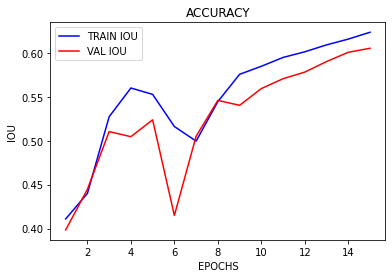

In [ ]:
#plot

results=model.evaluate(val_img,val_mask)
print("The accuracy is ")
print(results)
acc=history.history['calc_IOU']
val_acc=history.history['val_calc_IOU']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'-b',label="TRAIN IOU")
plt.plot(epochs,val_acc,'-r',label="VAL IOU")
plt.title("ACCURACY")
plt.xlabel("EPOCHS")
plt.ylabel("IOU")
plt.legend()
plt.show()

### SAVE the model in .h5 format. This can be loaded back. It stores all the weights for the model trained. 

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 

Saved model to disk


### CHECK BY UPLOADING AN IMAGE 

Saving X3-40-0.png to X3-40-0.png
Saving X3-40-1.png to X3-40-1.png
Saving X5-10-1.png to X5-10-1.png


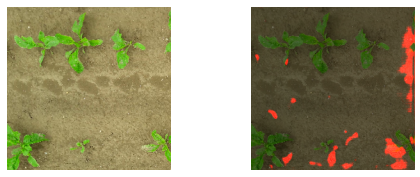

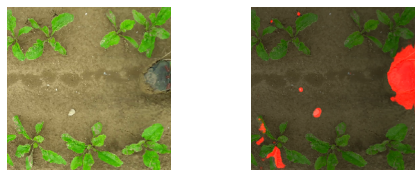

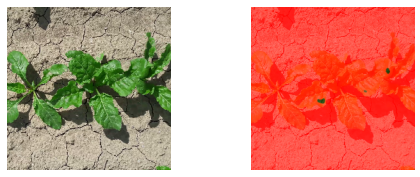

In [ ]:

# import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(256, 256))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x=x/255.0
  images = np.vstack([x])
  prediction = model.predict(images, batch_size=10)
  image_r=np.array(255*images[0],dtype=np.uint8)
  image_pred=np.array(255*prediction[0],dtype='uint8')
  rgb_pred=cv2.cvtColor(image_pred,cv2.COLOR_GRAY2RGB)
  rgb_pred[:,:,1:3]=0*rgb_pred[:,:,1:3]
  image_final=cv2.addWeighted(rgb_pred,1,image_r,0.5,0)
  plt.figure(figsize=(8,3))
  plt.subplot(1,2,1)
  plt.imshow(image_r)
  plt.title='Original image'
  plt.axis('off')
  plt.subplot(1,2,2)
  plt.imshow(image_final)
  plt.title='Predicted masks'
  plt.axis('off')




  

### View results for validation data (unseen data)

In [ ]:
pred_all= model.predict(val_img)
np.shape(pred_all)

for i in range(BATCH_SIZE):

    im = np.array(255*val_img[i],dtype=np.uint8)
    # im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im_mask = np.array(255*val_mask[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)
    im_pred1 = np.array(255*pred_all[i],dtype=np.uint8)
    
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred1 = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    temp1 = rgb_mask_pred[:,:,1:3]
    temp2 = rgb_mask_pred[:,:,1:2]
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:3]
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]

    img_pred = cv2.addWeighted(rgb_mask_pred,1,im,0.5,0)
    img_true = cv2.addWeighted(rgb_mask_true,1,im,0.5,0)

    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title='Original image'
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title='Predicted masks'
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(img_true)
    plt.title='ground truth datasets'
    plt.axis('off')
    plt.show()

### View results for some training data 

In [ ]:
train_img,train_mask=next(train_gen)
pred_all= model.predict(train_img)
np.shape(pred_all)

for i in range(BATCH_SIZE):

    im = np.array(255*train_img[i],dtype=np.uint8)
    # im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im_mask = np.array(255*train_mask[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)
    im_pred1 = np.array(255*pred_all[i],dtype=np.uint8)
    
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred1 = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    temp1 = rgb_mask_pred[:,:,1:3]
    temp2 = rgb_mask_pred[:,:,1:2]
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:3]
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]

    img_pred = cv2.addWeighted(rgb_mask_pred,1,im,0.5,0)
    img_true = cv2.addWeighted(rgb_mask_true,1,im,0.5,0)

    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title='Original image'
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title='Predicted masks'
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(img_true)
    plt.title='ground truth datasets'
    plt.axis('off')
    plt.show()
